<a href="https://colab.research.google.com/github/elphaskarter/transfer_learning/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from google.colab import drive

def main():
    drive.mount('/content/drive')
    data_dir  = '/content/drive/MyDrive/Images_Resnet'

    # Define transforms
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    # Load dataset and split
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = (len(dataset) - train_size) // 2
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42))

    # DataLoaders
    batch_size   = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Transfer learning
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torchvision.models.resnet18(weights='DEFAULT')  # Load pre-trained weights
    model.fc = torch.nn.Identity()                          # Remove classification head
    model = model.to(device)
    model.eval()

    # Feature extraction function
    def extract_features(loader):
        features, labels = [], []
        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                outputs = model(inputs).cpu().numpy()
                features.append(outputs)
                labels.append(targets.numpy())
        return np.concatenate(features), np.concatenate(labels)

    # Extract features
    train_features, train_labels = extract_features(train_loader)
    test_features, test_labels = extract_features(test_loader)

    # Train SVM
    clf = SVC(kernel='linear', C=1.0)
    clf.fit(train_features, train_labels)

    # Evaluate
    y_pred = clf.predict(test_features)
    accuracy = accuracy_score(test_labels, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_labels, y_pred, target_names=dataset.classes))
    print("\nConfusion Matrix:")
    print(confusion_matrix(test_labels, y_pred))

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.9381

Classification Report:
                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        14
         airplane       1.00      1.00      1.00         6
  baseballdiamond       0.89      0.80      0.84        10
            beach       1.00      1.00      1.00        10
        buildings       0.80      0.80      0.80        10
        chaparral       1.00      1.00      1.00        14
 denseresidential       0.50      1.00      0.67         4
           forest       1.00      1.00      1.00         8
          freeway       1.00      1.00      1.00         9
       golfcourse       1.00      1.00      1.00        11
           harbor       1.00      1.00      1.00        11
     intersection       1.00      0.60      0.75         5
mediumresidential       0.85      0.79      0.81        14
   

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
Train Loss: 2.2136 | Val Loss: 1.4611 | Val Acc: 0.7000
Epoch 2/20
Train Loss: 1.0835 | Val Loss: 0.9047 | Val Acc: 0.8143
Epoch 3/20
Train Loss: 0.7259 | Val Loss: 0.6916 | Val Acc: 0.8476
Epoch 4/20
Train Loss: 0.5448 | Val Loss: 0.5496 | Val Acc: 0.8905
Epoch 5/20
Train Loss: 0.4561 | Val Loss: 0.4945 | Val Acc: 0.8714
Epoch 6/20
Train Loss: 0.3845 | Val Loss: 0.4535 | Val Acc: 0.8857
Epoch 7/20
Train Loss: 0.3580 | Val Loss: 0.4303 | Val Acc: 0.8905
Epoch 8/20
Train Loss: 0.3056 | Val Loss: 0.3949 | Val Acc: 0.8857
Epoch 9/20
Train Loss: 0.2814 | Val Loss: 0.3908 | Val Acc: 0.8857
Epoch 10/20
Train Loss: 0.2669 | Val Loss: 0.3603 | Val Acc: 0.9000
Epoch 11/20
Train Loss: 0.2373 | Val Loss: 0.3592 | Val Acc: 0.8857
Epoch 12/20
Train Loss: 0.2357 | Val Loss: 0.3390 | Val Acc: 0.8952
Epoch 13/20
Train Loss: 0.2203 | Val Loss: 0.3312 | Val Acc: 0.8

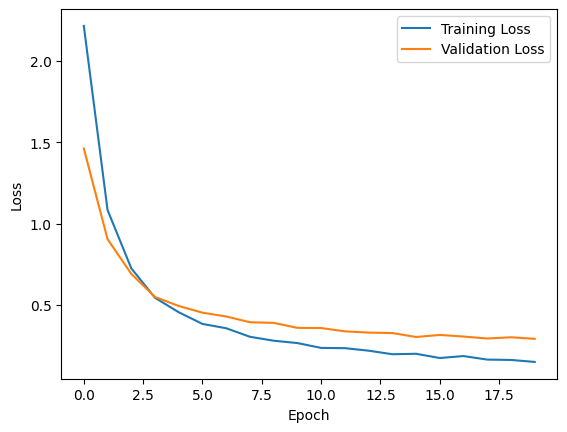

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

def main():
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = '/content/drive/MyDrive/Images_Resnet'

    # Defining transforms (same as Problem 2.a)
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    # Loading dataset and split (80-10-10)
    dataset    = datasets.ImageFolder(root=data_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size   = (len(dataset) - train_size) // 2
    test_size  = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42))

    # Create DataLoaders
    batch_size   = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Load pretrained ResNet18 and modify
    model    = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 21)  # 21 classes in UCMerced

    # Freeze all layers except the head
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    # Training setup
    device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model   = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=1e-3) # Here, we do parameter tuning on the classifier layer
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    # Track metrics
    train_losses, val_losses = [], []
    best_val_loss            = float('inf')
    best_model               = None

    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss    = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)
        train_loss = epoch_train_loss / len(train_dataset)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        epoch_val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss    = criterion(outputs, labels)
                epoch_val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)
        val_loss = epoch_val_loss / len(val_dataset)
        val_acc  = correct.double() / len(val_dataset)
        val_losses.append(val_loss)

        # Saving the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        scheduler.step()

    # Loading the best model and test
    model.load_state_dict(best_model)
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    # Metrics
    print("\nTest Results:")
    print(f"Accuracy: {accuracy_score(test_labels, test_preds):.4f}")
    print(classification_report(test_labels, test_preds, target_names=dataset.classes))
    print("Confusion Matrix:")
    print(confusion_matrix(test_labels, test_preds))

    # Plot losses
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()